In [1]:
import os
import pickle
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.functional as F
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

In [2]:
from meta_load import *

In [3]:
df = load_meta_v2()
df

6 4133
(4133, 36) (4133,) (4133,) (4133,)


,SenteraASM15_0,SenteraASM15_90,SenteraASM30_0,SenteraASM30_90,SenteraASM50_0,SenteraASM50_90,Senteracontrast15_0,Senteracontrast15_90,Senteracontrast30_0,Senteracontrast30_90,...,Senteraenergy50_90,Senterahomogeneity15_0,Senterahomogeneity15_90,Senterahomogeneity30_0,Senterahomogeneity30_90,Senterahomogeneity50_0,Senterahomogeneity50_90,fly,landmark,Place
0,0.000705,0.000711,0.000594,0.000592,0.000560,0.000559,143.419535,127.969690,200.391433,196.198353,...,0.023634,0.144670,0.144798,0.116794,0.115318,0.106531,0.105428,8,N_Control,10_A
1,0.000855,0.000869,0.000725,0.000722,0.000690,0.000680,112.393476,104.478127,154.060668,155.406801,...,0.026083,0.151051,0.152582,0.122054,0.121578,0.112162,0.110044,8,P_Control,10_B
2,0.000813,0.000833,0.000672,0.000673,0.000635,0.000637,123.028084,106.878970,183.036163,180.869956,...,0.025233,0.147733,0.151046,0.115586,0.115848,0.105117,0.105493,8,K_Control,10_C
3,0.000728,0.000766,0.000647,0.000642,0.000618,0.000607,151.597590,132.826108,193.162567,206.125643,...,0.024637,0.131963,0.140764,0.112058,0.111860,0.103291,0.103053,8,Control,10_D
4,0.000926,0.000944,0.000776,0.000771,0.000737,0.000721,117.817314,100.882589,167.043099,161.468386,...,0.026853,0.158860,0.162291,0.127165,0.126652,0.118328,0.113454,8,H50%,10_E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4128,0.000449,0.000461,0.000397,0.000400,0.000374,0.000378,291.551824,279.614601,357.266417,356.500160,...,0.019449,0.116537,0.120360,0.100817,0.102188,0.092546,0.095513,12,K_Control,9_C
4129,0.000389,0.000401,0.000342,0.000351,0.000325,0.000337,329.941675,309.016892,396.023013,383.123028,...,0.018349,0.102952,0.105841,0.086658,0.089652,0.079483,0.083362,12,Control,9_D
4130,0.000531,0.000527,0.000468,0.000471,0.000451,0.000453,259.923293,263.598031,314.750834,312.506270,...,0.021276,0.114995,0.113984,0.097978,0.097928,0.092691,0.092209,12,H50%,9_E
4131,0.000394,0.000403,0.000348,0.000354,0.000332,0.000341,338.214450,322.251519,402.663766,391.480817,...,0.018455,0.107977,0.111161,0.092265,0.093713,0.085414,0.087113,12,H75%,9_F


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [5]:
N_data = df[(df['landmark']=='N_Control') | (df['landmark']=='N_Exceso') | (df['landmark']=='N_Deficiencia')]
#optional
N_data = N_data.iloc[:,[4,5,10,11,16,17,22,23,28,29,34,35,36,37,38]]
print(N_data.columns)
N_data = N_data[N_data['fly']!=0]
N_data

Index(['SenteraASM50_0', 'SenteraASM50_90', 'Senteracontrast50_0',
       'Senteracontrast50_90', 'Senteracorrelation50_0',
       'Senteracorrelation50_90', 'Senteradissimilarity50_0',
       'Senteradissimilarity50_90', 'Senteraenergy50_0', 'Senteraenergy50_90',
       'Senterahomogeneity50_0', 'Senterahomogeneity50_90', 'fly', 'landmark',
       'Place'],
      dtype='object')


,SenteraASM50_0,SenteraASM50_90,Senteracontrast50_0,Senteracontrast50_90,Senteracorrelation50_0,Senteracorrelation50_90,Senteradissimilarity50_0,Senteradissimilarity50_90,Senteraenergy50_0,Senteraenergy50_90,Senterahomogeneity50_0,Senterahomogeneity50_90,fly,landmark,Place
0,0.000560,0.000559,218.931111,219.047059,0.385036,0.382759,11.041644,11.056423,0.023664,0.023634,0.106531,0.105428,8,N_Control,10_A
5,0.000381,0.000383,302.398967,299.681248,0.367352,0.371699,13.224918,13.158797,0.019511,0.019573,0.086932,0.086379,8,N_Control,11_A
14,0.000740,0.000737,194.193897,192.186004,0.340949,0.347341,10.389573,10.355175,0.027209,0.027140,0.112421,0.112791,8,N_Control,13_A
19,0.000589,0.000578,211.280959,216.151676,0.365355,0.349626,10.963472,11.088518,0.024268,0.024038,0.105244,0.103858,8,N_Control,14_A
25,0.001016,0.001005,125.493477,129.942448,0.389787,0.368334,8.384933,8.504090,0.031880,0.031707,0.130143,0.130093,8,N_Deficiencia,15_A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4098,0.000355,0.000356,401.295713,406.205535,0.309834,0.301848,14.724052,14.745610,0.018836,0.018858,0.087387,0.088539,12,N_Exceso,5_A
4105,0.000212,0.000212,775.322718,773.187599,0.237944,0.241044,20.692041,20.709060,0.014551,0.014546,0.066327,0.064902,12,N_Exceso,6_A
4112,0.000346,0.000347,481.172257,486.141844,0.332131,0.325299,15.667647,15.703994,0.018600,0.018629,0.098011,0.097584,12,N_Exceso,7_A
4119,0.000319,0.000332,403.020283,391.572719,0.349588,0.363965,15.088874,14.694055,0.017864,0.018217,0.080117,0.085360,12,N_Control,8_A


In [6]:
n2clas={'N_Deficiencia':0, 'N_Control':1, 'N_Exceso':2}

In [7]:
N_data.landmark.replace(n2clas, inplace=True)
N_data

,SenteraASM50_0,SenteraASM50_90,Senteracontrast50_0,Senteracontrast50_90,Senteracorrelation50_0,Senteracorrelation50_90,Senteradissimilarity50_0,Senteradissimilarity50_90,Senteraenergy50_0,Senteraenergy50_90,Senterahomogeneity50_0,Senterahomogeneity50_90,fly,landmark,Place
0,0.000560,0.000559,218.931111,219.047059,0.385036,0.382759,11.041644,11.056423,0.023664,0.023634,0.106531,0.105428,8,1,10_A
5,0.000381,0.000383,302.398967,299.681248,0.367352,0.371699,13.224918,13.158797,0.019511,0.019573,0.086932,0.086379,8,1,11_A
14,0.000740,0.000737,194.193897,192.186004,0.340949,0.347341,10.389573,10.355175,0.027209,0.027140,0.112421,0.112791,8,1,13_A
19,0.000589,0.000578,211.280959,216.151676,0.365355,0.349626,10.963472,11.088518,0.024268,0.024038,0.105244,0.103858,8,1,14_A
25,0.001016,0.001005,125.493477,129.942448,0.389787,0.368334,8.384933,8.504090,0.031880,0.031707,0.130143,0.130093,8,0,15_A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4098,0.000355,0.000356,401.295713,406.205535,0.309834,0.301848,14.724052,14.745610,0.018836,0.018858,0.087387,0.088539,12,2,5_A
4105,0.000212,0.000212,775.322718,773.187599,0.237944,0.241044,20.692041,20.709060,0.014551,0.014546,0.066327,0.064902,12,2,6_A
4112,0.000346,0.000347,481.172257,486.141844,0.332131,0.325299,15.667647,15.703994,0.018600,0.018629,0.098011,0.097584,12,2,7_A
4119,0.000319,0.000332,403.020283,391.572719,0.349588,0.363965,15.088874,14.694055,0.017864,0.018217,0.080117,0.085360,12,1,8_A


In [8]:
N_data.shape

(540, 15)

In [108]:

class datapaltas(Dataset):
    def __init__(self, df=N_data, scale =True):
        self.df = df

    def __getitem__(self, index):
        X = (self.df.iloc[index,:12]).values
        X = X.astype(np.float64)
        X = torch.from_numpy(X).float()
        y = self.df.iloc[index,13]
        #print(y)
        y = torch.Tensor([y]).long()
        return X, y
    
    def __len__(self):
        return self.df.shape[0]

In [109]:
class SimpleClassification(nn.Module):
    
    def __init__(self, n_features = 12, n_classes = 3):
        super(SimpleClassification, self).__init__()
        
        self.l1 = nn.Linear(n_features, 128)
        self.l2 = nn.Linear(128, 64)
        self.l3 = nn.Linear(64, 32)
        self.l4 = nn.Linear(32, 16)
        self.l5 = nn.Linear(16, n_classes)
        
        self.relu = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm1d(128)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.batchnorm3 = nn.BatchNorm1d(32)
        self.batchnorm4 = nn.BatchNorm1d(16)
    
    def forward(self, x):
        x = self.relu(self.batchnorm1(self.l1(x)))
        x = self.relu(self.batchnorm2(self.l2(x)))
        x = self.relu(self.batchnorm3(self.l3(x)))
        x = self.relu(self.batchnorm4(self.l4(x)))
        return self.l5(x)

In [110]:
a = datapaltas()
a[0], a[4]

((tensor([5.5998e-04, 5.5856e-04, 2.1893e+02, 2.1905e+02, 3.8504e-01, 3.8276e-01,
          1.1042e+01, 1.1056e+01, 2.3664e-02, 2.3634e-02, 1.0653e-01, 1.0543e-01]),
  tensor([1])),
 (tensor([1.0163e-03, 1.0053e-03, 1.2549e+02, 1.2994e+02, 3.8979e-01, 3.6833e-01,
          8.3849e+00, 8.5041e+00, 3.1880e-02, 3.1707e-02, 1.3014e-01, 1.3009e-01]),
  tensor([0])))

In [111]:
a = datapaltas()
train_loader = DataLoader(dataset=a, batch_size=64)
model = SimpleClassification()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
print(model)


SimpleClassification(
  (l1): Linear(in_features=12, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=64, bias=True)
  (l3): Linear(in_features=64, out_features=32, bias=True)
  (l4): Linear(in_features=32, out_features=16, bias=True)
  (l5): Linear(in_features=16, out_features=3, bias=True)
  (relu): ReLU()
  (batchnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [112]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

def F1_score(prob, label):
    y_pred_softmax = torch.log_softmax(prob, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
    #print(y_pred_tags, label)
    return f1_score(label.cpu(), y_pred_tags.cpu(), average='macro')

Fold 1
------------------------


Acc train: 64.43 Acc test: 45.37 F1 train: 0.63 F1 test: 0.45: 100%|█| 300/300 [02:15<00:00,  2.2


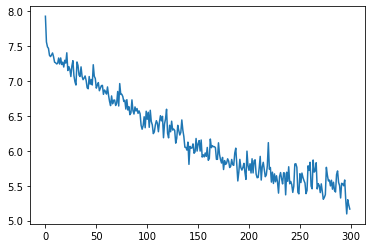

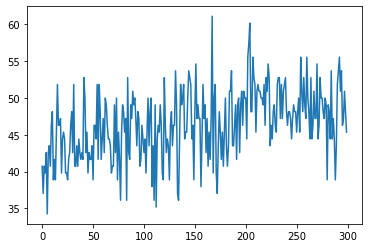

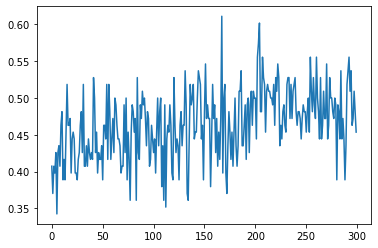

Fold 2
------------------------


Acc train: 60.57 Acc test: 43.52 F1 train: 0.59 F1 test: 0.44: 100%|█| 300/300 [02:47<00:00,  1.8


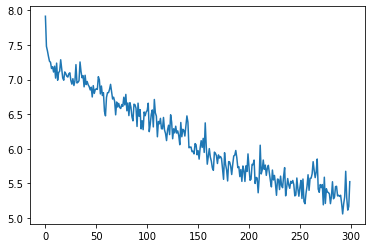

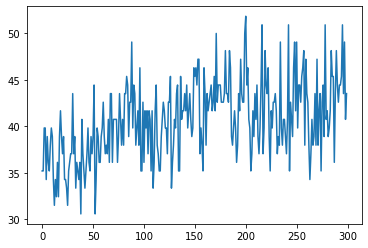

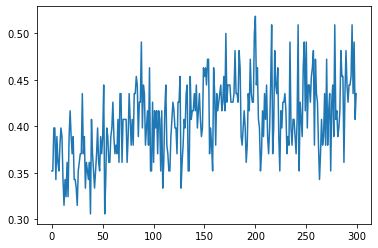

Fold 3
------------------------


Acc train: 62.29 Acc test: 47.22 F1 train: 0.61 F1 test: 0.47: 100%|█| 300/300 [02:27<00:00,  2.0


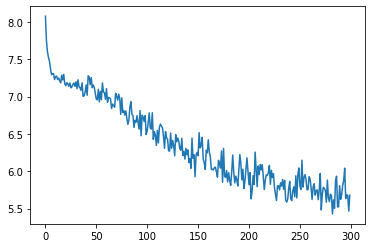

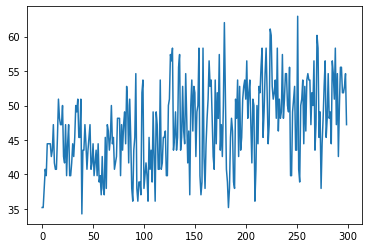

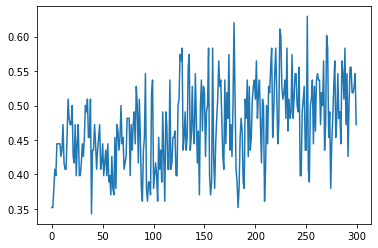

Fold 4
------------------------


Acc train: 61.57 Acc test: 47.22 F1 train: 0.61 F1 test: 0.47: 100%|█| 300/300 [02:30<00:00,  1.9


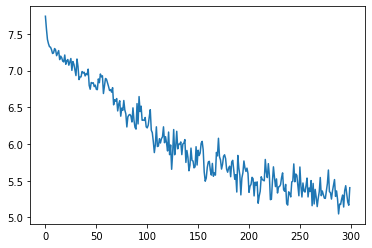

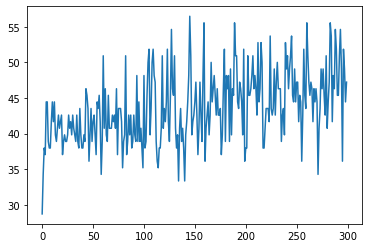

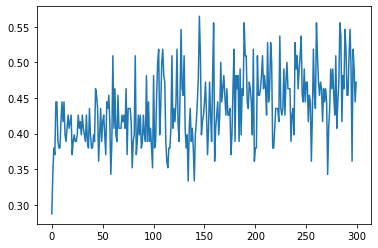

Fold 5
------------------------


Acc train: 62.43 Acc test: 50.93 F1 train: 0.61 F1 test: 0.51: 100%|█| 300/300 [02:29<00:00,  2.0


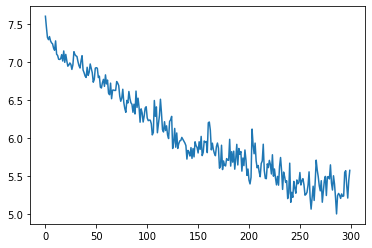

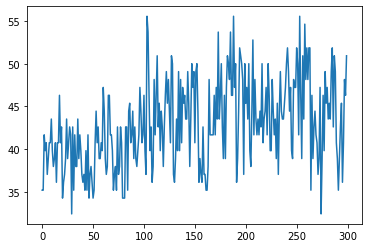

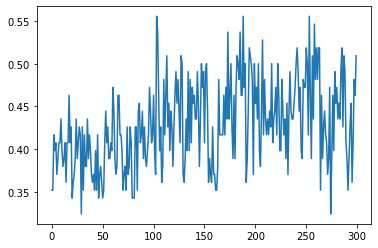

In [113]:
EPOCHS = 100

skf = StratifiedKFold()
skf.get_n_splits(N_data, N_data.iloc[:,13])
for fold, (train_ids, test_ids) in enumerate(skf.split(N_data, N_data.iloc[:,13])):
    l_v = []
    a_v = []
    f_v = []
    print(f'Fold {fold+1}')
    print('------------------------')
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    train_loader = torch.utils.data.DataLoader(
                      a, 
                      batch_size=64, sampler=train_subsampler)
    test_loader = torch.utils.data.DataLoader(
                      a,
                      batch_size=1, sampler=test_subsampler)
    model = SimpleClassification()
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.001)
    itt = tqdm(range(EPOCHS))
    for i in itt:
        loss_epoch = 0
        acc_train, acc_test = 0, 0
        f1_train, f1_test = 0, 0
        model.train()
        for X, y in train_loader:
            X, y = X.to(device), y.to(device).flatten()
            optimizer.zero_grad()
            y_pred = model(X)
            loss = criterion(y_pred, y)
            acc = multi_acc(y_pred, y)
            f1 = F1_score(y_pred, y)
            loss.backward()
            optimizer.step()
            loss_epoch += loss.item()
            acc_train += acc.item()
            f1_train += f1.item()
            
        with torch.no_grad():
            
            for X, y in test_loader:
                X, y = X.to(device), y.to(device).flatten()
                model.eval()
                output = model(X)
                acc = multi_acc(output, y)
                f1 = F1_score(output, y)
                acc_test += acc.item()
                f1_test += f1.item()
        
        itt.set_description("Acc train: %.2f Acc test: %.2f F1 train: %.2f F1 test: %.2f" % (acc_train/len(train_loader), acc_test/len(test_loader), f1_train/len(train_loader), f1_test/len(test_loader)))
            
        l_v.append(loss_epoch)
        a_v.append(acc_test/len(test_loader))
        f_v.append(f1_test/len(test_loader))
        #print(f'Loss {i+1}: {loss_epoch}')
        #print(f'Acc {i+1}: {acc_epoch/len(train_loader)}')
        #print(f'F1 {i+1}: {f1_epoch/len(train_loader)}')
    plt.figure(), plt.plot(l_v)
    plt.figure(), plt.plot(a_v)
    plt.figure(), plt.plot(f_v)
    plt.show()

100%|██████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  2.95it/s]


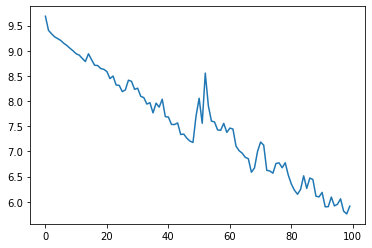

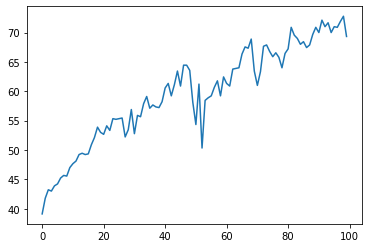

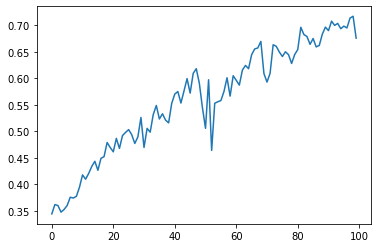

In [52]:
EPOCHS = 100
l_v = []
a_v = []
f_v = []
for i in tqdm(range(EPOCHS)):
    loss_epoch = 0
    acc_epoch = 0
    f1_epoch = 0
    model.train()
    for X, y in train_loader:
        X, y = X.to(device), y.to(device).flatten()
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        acc = multi_acc(y_pred, y)
        f1 = F1_score(y_pred, y)
        loss.backward()
        optimizer.step()
        loss_epoch += loss.item()
        acc_epoch += acc.item()
        f1_epoch += f1.item()
    l_v.append(loss_epoch)
    a_v.append(acc_epoch/len(train_loader))
    f_v.append(f1_epoch/len(train_loader))
    #print(f'Loss {i+1}: {loss_epoch}')
    #print(f'Acc {i+1}: {acc_epoch/len(train_loader)}')
    #print(f'F1 {i+1}: {f1_epoch/len(train_loader)}')
plt.figure(), plt.plot(l_v)
plt.figure(), plt.plot(a_v)
plt.figure(), plt.plot(f_v)
plt.show()